# Introduction to object-oriented programming (OOP)

In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

## Example of non-OOP code: Lennard-Jones particles in a box

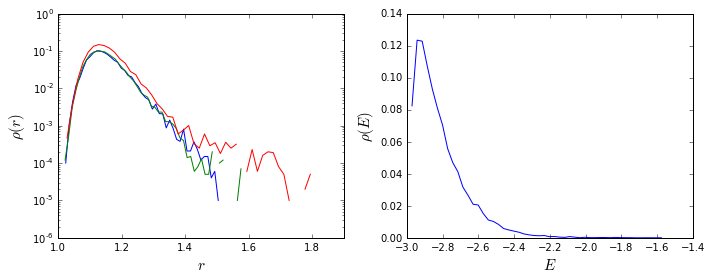

In [2]:
def lj_potential(r, sigma=1.0, epsilon=1.0):
    r"""
    Compute the Lennard-Jones potential.
    
    Parameters
    ----------
    r : float or array-like of float
        Euklidean particle-particle distance(s).
    sigma : float, optional, default=1.0
        Zero crossing distance.
    epsilon : float, optional, default=1.0
        Depth of the potential well.
    
    Returns
    -------
    float or array-like of float
        Lennard-Jones energy value(s).
    
    """
    q = (sigma / r)**6
    return 4.0 * (epsilon * (q * (q - 1.0)))

def interaction_potential(xyz, sigma=1.0, epsilon=1.0):
    r"""
    Compute the interaction potential for a set of particles.
    
    Parameters
    ----------
    xyz : numpy.ndarray(shape=(n, d))
        d-dimensional coordinates of n particles.
    sigma : float, optional, default=1.0
        Zero crossing distance for the Lennard-Jones contribution.
    epsilon : float, optional, default=1.0
        Depth of the potential well for the Lennard-Jones contribution.
    
    Returns
    -------
    float
        Total interaction potential.
    
    """
    lj_interaction = 0.0
    for i in range(1, xyz.shape[0]):
        lj_interaction_tmp = 0.0
        for j in range(i):
            r = np.linalg.norm(xyz[j, :] - xyz[i, :])
            lj_interaction_tmp += lj_potential(r, sigma=sigma, epsilon=epsilon)
        lj_interaction += lj_interaction_tmp
    return lj_interaction

def external_potential(xyz, box_length=None):
    r"""
    Compute the external potential for a set of particles.
    
    Parameters
    ----------
    xyz : numpy.ndarray(shape=(n, d))
        d-dimensional coordinates of n particles.
    box_length : float, optional, default=None
        If not None, the area outside [0, box_length]^d
        is forbidden for each particle.
    
    Returns
    -------
    float
        Total external potential.
    
    """
    if box_length is None:
        return 0.0
    if np.all(xyz >= 0.0) and np.all(xyz <= box_length):
        return 0.0
    return np.inf

def phi(xyz, sigma=1.0, epsilon=1.0, box_length=None):
    r"""
    Compute the interaction and external potential for a set of particles.
    
    Parameters
    ----------
    xyz : numpy.ndarray(shape=(n, d))
        d-dimensional coordinates of n particles.
    sigma : float, optional, default=1.0
        Zero crossing distance for the Lennard-Jones contribution.
    epsilon : float, optional, default=1.0
        Depth of the potential well for the Lennard-Jones contribution.
    box_length : float, optional, default=None
        If not None, the area outside [0, box_length]^d
        is forbidden for each particle.
    
    Returns
    -------
    float
        Total interaction and external potential.
    
    """
    return interaction_potential(xyz, sigma=sigma, epsilon=epsilon) + external_potential(xyz, box_length=box_length)

def metropolis_update(xyz, pot, sigma=1.0, epsilon=1.0, box_length=None, step=0.1, beta=1.0):
    r"""
    Perform a Metropolis update step.
    
    Parameters
    ----------
    xyz : numpy.ndarray(shape=(n, d))
        d-dimensional coordinates of n particles.
    pot : float
        Potential value of xyz.
    sigma : float, optional, default=1.0
        Zero crossing distance for the Lennard-Jones contribution.
    epsilon : float, optional, default=1.0
        Depth of the potential well for the Lennard-Jones contribution.
    box_length : float, optional, default=None
        If not None, the area outside [0, box_length]^d
        is forbidden for each particle.
    step : float, optional, default=0.1
        Maximal size of an update move in each coordinate.
    beta : float, optional, default=1.0
        Inverse temperature factor (1/kT).
    
    Returns
    -------
    float
        Total interaction and external potential.
    
    """
    xyz_trial = xyz + 2.0 * step * (np.random.rand(*xyz.shape) - 0.5)
    pot_trial = phi(xyz_trial, sigma=sigma, epsilon=epsilon, box_length=box_length)
    if pot_trial <= pot or np.random.rand() < np.exp(beta * (pot - pot_trial)):
        return xyz_trial, pot_trial
    return xyz, pot

def metropolis(xyz_init, size, sigma=1.0, epsilon=1.0, box_length=None, step=0.1, beta=1.0):
    r"""
    Perform a Metropolis MC sampling procedure.
    
    Parameters
    ----------
    xyz_init : numpy.ndarray(shape=(n, d)) or similar
        Initial d-dimensional coordinates of n particles.
    size : int
        Number of Metropolis update steps.
    sigma : float, optional, default=1.0
        Zero crossing distance for the Lennard-Jones contribution.
    epsilon : float, optional, default=1.0
        Depth of the potential well for the Lennard-Jones contribution.
    box_length : float, optional, default=None
        If not None, the area outside [0, box_length]^d
        is forbidden for each particle.
    step : float, optional, default=0.1
        Maximal size of an update move in each coordinate.
    beta : float, optional, default=1.0
        Inverse temperature factor (1/kT).
    
    Returns
    -------
    float
        Total interaction and external potential.
    
    """
    xyz_traj = [np.asarray(xyz_init, dtype=np.float64)]
    pot_traj = [phi(xyz_traj[-1], sigma=sigma, epsilon=epsilon, box_length=box_length)]
    for i in range(size):
        xyz, pot = metropolis_update(
            xyz_traj[-1], pot_traj[-1],
            sigma=sigma, epsilon=epsilon, box_length=box_length,
            step=step, beta=beta)
        xyz_traj.append(xyz)
        pot_traj.append(pot)
    return np.asarray(xyz_traj, dtype=np.float64), np.asarray(pot_traj, dtype=np.float64)

def metropolis_sa(xyz_init, size, sigma=1.0, epsilon=1.0, box_length=None, step=0.1, beta=1.0):
    r"""
    Perform a Metropolis-based simulated annealing procedure.
    
    Parameters
    ----------
    xyz_init : numpy.ndarray(shape=(n, d)) or similar
        Initial d-dimensional coordinates of n particles.
    size : int
        Number of Metropolis update steps.
    sigma : float, optional, default=1.0
        Zero crossing distance for the Lennard-Jones contribution.
    epsilon : float, optional, default=1.0
        Depth of the potential well for the Lennard-Jones contribution.
    box_length : float, optional, default=None
        If not None, the area outside [0, box_length]^d
        is forbidden for each particle.
    step : float, optional, default=0.1
        Maximal size of an update move in each coordinate.
    beta : float, optional, default=1.0
        Initial inverse temperature factor (1/kT).
    
    Returns
    -------
    float
        Total interaction and external potential.
    
    """
    beta_values = 1.0 / np.linspace(1.0E-15, 1.0 / beta, size)[::-1]
    xyz_traj = [np.asarray(xyz_init, dtype=np.float64)]
    pot_traj = [phi(xyz_traj[-1], sigma=sigma, epsilon=epsilon, box_length=box_length)]
    for i in range(size):
        xyz, pot = metropolis_update(
            xyz_traj[-1], pot_traj[-1],
            sigma=sigma, epsilon=epsilon, box_length=box_length,
            step=step, beta=beta_values[i])
        xyz_traj.append(xyz)
        pot_traj.append(pot)
    return np.asarray(xyz_traj, dtype=np.float64), np.asarray(pot_traj, dtype=np.float64)

# APPLY THE CODE

xyz, pot = metropolis(np.random.rand(3, 3) * 2.0, 101000, box_length=2.0, beta=10.0)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
for i in range(1, xyz.shape[1]):
    for j in range(i):
        hist, edges = np.histogram(np.linalg.norm(xyz[1000:, j, :] - xyz[1000:, i, :], axis=-1), bins=50)
        rho = hist.astype(np.float64) / np.sum(hist)
        axes[0].plot(edges[1:], rho)
axes[0].set_xlabel(r"$r$", fontsize=15)
axes[0].set_ylabel(r"$\rho(r)$", fontsize=15)
axes[0].semilogy()
hist, edges = np.histogram(pot[1000:], bins=50)
rho = hist.astype(np.float64) / np.sum(hist)
axes[1].plot(edges[1:], rho)
axes[1].set_xlabel(r"$E$", fontsize=15)
axes[1].set_ylabel(r"$\rho(E)$", fontsize=15)
fig.tight_layout()

**Goal of OOP**: encapsulate/bundle system parameters and functions in logical units.

## Some examples of Python classes

In [3]:
class MyClass(object):
    """Class docstring"""

    def __init__(self, parameter):
        """constructor"""
        self.parameter = parameter

    def __repr__(self):
        return "My parameter is '%s'" % self.parameter

    def print_me(self, argument=None):
        if argument is None:
            print(self)
        else:
            print(argument)

obj = MyClass("test")
print(obj)
obj.print_me()
obj.print_me(argument="Hello, world!")

My parameter is 'test'
My parameter is 'test'
Hello, world!


In [4]:
class MyCounter(object):
    def __init__(self):
        self.counter = 0
    def increment(self):
        self.counter += 1
        return self.counter

counter = MyCounter().increment

for i in range(5):
    print(counter())

1
2
3
4
5


## Make a class for the Lennard-Jones potential

**Goal**: encapsulate $\sigma$ and $\epsilon$, and provide simple checks.

(1.0, 1.0)


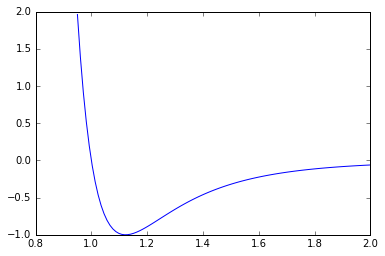

In [5]:
class LennardJonesPotential(object):
    r"""
    A class to encapsule the LJ potential function and it's parameters.

    Parameters
    ----------
    sigma : float, optional, default=1.0
        Zero crossing distance, must be positive.
    epsilon : float, optional, default=1.0
        Depth of the potential well for the Lennard-Jones contribution,
        must be non-negative.

    """

    def __init__(self, sigma=1.0, epsilon=1.0):
        self.sigma = sigma
        self.epsilon = epsilon

    @property
    def sigma(self):
        return self._sigma
    @sigma.setter
    def sigma(self, value):
        if not isinstance(value, (float, int)) or value <= 0.0:
            raise ValueError("sigma must be a positive number")
        self._sigma = float(value)

    @property
    def epsilon(self):
        return self._epsilon
    @epsilon.setter
    def epsilon(self, value):
        if not isinstance(value, (float, int)) or value < 0.0:
            raise ValueError("epsilon must be a non.negative number")
        self._epsilon = float(value)

    def potential(self, r):
        r"""
        Compute the Lennard-Jones potential.

        Parameters
        ----------
        r : float or array-like of float
            Euklidean particle-particle distance(s).

        Returns
        -------
        float or array-like of float
            Lennard-Jones energy value(s).

        """
        q = (self.sigma / r)**6
        return 4.0 * (self.epsilon * (q * (q - 1.0)))

lj = LennardJonesPotential()
print(lj.epsilon, lj.sigma)

x = np.linspace(0.95, 2.0, 100)
plt.plot(x, lj.potential(x))

## Derive a class for the system in a box

**Goal**: encapsulate the box and LJ parameters and provide a potential method and further checks.

In [6]:
class LennardJonesBox(LennardJonesPotential):
    r"""
    A class to encapsule a system of LJ particles,
    free or in a box with infinte walls.

    Parameters
    ----------
    xyz : numpy.ndarray(shape=(n, d)) or similar
        Initial d-dimensional coordinates of n particles.
    box : float, optional, default=None
        If not None, the area outside [0, box_length]^d
        is forbidden for each particle.
    sigma : float, optional, default=1.0
        Zero crossing distance, must be positive.
    epsilon : float, optional, default=1.0
        Depth of the potential well for the Lennard-Jones
        contribution, must be non-negative.

    """
    
    def __init__(self, xyz, box=None, beta=1.0, sigma=1.0, epsilon=1.0):
        super(LennardJonesBox, self).__init__(sigma=sigma, epsilon=epsilon)
        self.xyz = xyz
        self.box = box
        if self._external_potential() == np.inf:
            raise ValueError("xyz does not fit in box!")

    @property
    def xyz(self):
        return self._xyz
    @xyz.setter
    def xyz(self, value):
        xyz = np.asarray(value)
        if xyz.ndim != 2 or xyz.shape[0] < 2 or xyz.shape[1] not in (1, 2, 3):
            raise ValueError("xyz must be of shape=(np, dim) with np > 1 and dim = 1, 2, 3")
        self._xyz = xyz

    @property
    def box(self):
        return self._box
    @box.setter
    def box(self, value):
        if value is None:
            self._box = None
        elif not isinstance(value, (float, int)) or value <= 0.0:
            raise ValueError("box must be a positive number or None")
        self._box = float(value)

    def _interaction_potential(self, xyz=None):
        if xyz is None:
            xyz = self.xyz
        lj_interaction = 0.0
        for i in range(1, xyz.shape[0]):
            lj_interaction_tmp = 0.0
            for j in range(i):
                r = np.linalg.norm(xyz[j, :] - xyz[i, :])
                lj_interaction_tmp += super(LennardJonesBox, self).potential(r)
            lj_interaction += lj_interaction_tmp
        return lj_interaction

    def _external_potential(self, xyz=None):
        if xyz is None:
            xyz = self.xyz
        if self.box is None:
            return 0.0
        if np.all(xyz >= 0.0) and np.all(xyz <= self.box):
            return 0.0
        return np.inf

    def potential(self, xyz=None):
        r"""
        Compute the interaction and external potential
        for the current set of particles.

        Parameters
        ----------
        xyz : numpy.ndarray(shape=(n, d)) or similar, optional, default=None
            d-dimensional coordinates of n particles;
            if None, self.xyz is used.

        Returns
        -------
        float
            Total interaction and external potential.

        """
        if xyz is None:
            xyz = self.xyz
        else:
            xyz = np.asarray(xyz)
        return self._interaction_potential(xyz=xyz) + self._external_potential(xyz=xyz)

ljb = LennardJonesBox([[0.1, 0.1], [1.5, 1.5]], box=2.0)
print(ljb.potential())
print(ljb.potential([[0.1, 0.1], [2.5, 2.5]]))

-0.0653027431851
inf


## Make a class to handle Metropolis and simulated annealing

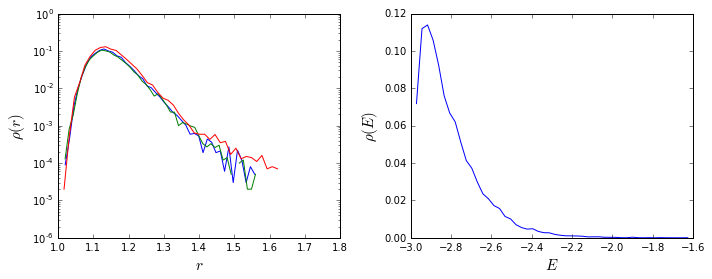

In [7]:
class Sampler(object):
    r"""A sampler class for hamiltonian objects."""

    def _update(self, hamiltonian, xyz, pot, step, beta):
        xyz_trial = xyz + 2.0 * step * (np.random.rand(*xyz.shape) - 0.5)
        pot_trial = hamiltonian.potential(xyz=xyz_trial)
        if pot_trial <= pot or np.random.rand() < np.exp(beta * (pot - pot_trial)):
            return xyz_trial, pot_trial
        return xyz, pot

    def metropolis(self, hamiltonian, size, step=0.1, beta=1.0):
        r"""
        Perform a Metropolis MC sampling procedure.

        Parameters
        ----------
        hamiltonian : object
            Encapsulates the system's degrees of freedom
            and interactions.
        size : int
            Number of Metropolis update steps.
        step : float, optional, default=0.1
            Maximal size of an update move in each coordinate.
        beta : float, optional, default=1.0
            Inverse temperature factor (1/kT).

        Returns
        -------
        numpy.ndarray of float
            Configuration trajectory.
        numpy.ndarray of float
            Total interaction and external potential trajectory.

        """
        xyz_traj = [np.asarray(hamiltonian.xyz, dtype=np.float64)]
        pot_traj = [hamiltonian.potential()]
        for i in range(size):
            xyz, pot = self._update(
                hamiltonian,
                xyz_traj[-1], pot_traj[-1],
                step=step, beta=beta)
            xyz_traj.append(xyz)
            pot_traj.append(pot)
        hamiltonian.xyz[:] = xyz_traj[-1]
        return np.asarray(xyz_traj, dtype=np.float64), np.asarray(pot_traj, dtype=np.float64)

    def metropolis_sa(self, hamiltonian, size, step=0.1, beta=1.0):
        r"""
        Perform a Metropolis-based simulated annealing procedure.

        Parameters
        ----------
        hamiltonian : object
            Encapsulates the system's degrees of freedom
            and interactions.
        size : int
            Number of Metropolis update steps.
        step : float, optional, default=0.1
            Maximal size of an update move in each coordinate.
        beta : float, optional, default=1.0
            Initial inverse temperature factor (1/kT).

        Returns
        -------
        numpy.ndarray of float
            Configuration trajectory.
        numpy.ndarray of float
            Total interaction and external potential trajectory.
    
        """
        beta_values = 1.0 / np.linspace(1.0E-15, 1.0 / beta, size)[::-1]
        xyz_traj = [np.asarray(hamiltonian.xyz, dtype=np.float64)]
        pot_traj = [hamiltonian.potential()]
        for i in range(size):
            xyz, pot = self._update(
                hamiltonian,
                xyz_traj[-1], pot_traj[-1],
                step=step, beta=beta_values[i])
            xyz_traj.append(xyz)
            pot_traj.append(pot)
        hamiltonian.xyz[:] = xyz_traj[-1]
        return np.asarray(xyz_traj, dtype=np.float64), np.asarray(pot_traj, dtype=np.float64)

hamiltonian = LennardJonesBox(np.random.rand(3, 3) * 2.0, box=2.0)
sampler = Sampler()

xyz_sa, pot_sa = sampler.metropolis_sa(hamiltonian, 1000, step=0.1, beta=10.0)
xyz_eq, pot_eq = sampler.metropolis(hamiltonian, 1000, step=0.1, beta=10.0)
xyz, pot = sampler.metropolis(hamiltonian, 100000, step=0.1, beta=10.0)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
for i in range(1, xyz.shape[1]):
    for j in range(i):
        hist, edges = np.histogram(np.linalg.norm(xyz[:, j, :] - xyz[:, i, :], axis=-1), bins=50)
        rho = hist.astype(np.float64) / np.sum(hist)
        axes[0].plot(edges[1:], rho)
axes[0].set_xlabel(r"$r$", fontsize=15)
axes[0].set_ylabel(r"$\rho(r)$", fontsize=15)
axes[0].semilogy()
hist, edges = np.histogram(pot[:], bins=50)
rho = hist.astype(np.float64) / np.sum(hist)
axes[1].plot(edges[1:], rho)
axes[1].set_xlabel(r"$E$", fontsize=15)
axes[1].set_ylabel(r"$\rho(E)$", fontsize=15)
fig.tight_layout()

In [13]:
%%timeit

sampler.metropolis(hamiltonian, 1000)

10 loops, best of 3: 93.6 ms per loop


In [12]:
%%timeit

metropolis(hamiltonian.xyz, 1000)

10 loops, best of 3: 62.7 ms per loop
